In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix as cm,
    accuracy_score as acc,
    precision_score as prec,
    recall_score as rec,
    f1_score as f1
)
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from ml_model_eval import pred_proba_plot, plot_cross_val_confusion_matrix, plot_learning_curve

In [4]:
matches = pd.read_csv("../matches_after_preprocessing.csv")

In [5]:
train = matches[matches["date"] < '2022-11-01']
test = matches[matches["date"] > '2022-11-01']
predictors = ["venue_code", "opp_code", "hour", "day_code", "gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"]
X_train = train[predictors]
y_train = train["target"]
X_test = test[predictors]
y_test = test["target"]
X_test.drop(["gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"], axis =1)

,venue_code,opp_code,hour,day_code
0,0,10,12,5
1,1,3,16,6
2,0,16,16,6
3,1,19,15,5
4,1,2,15,5
...,...,...,...,...
1717,0,17,14,6
1718,0,19,20,0
1719,1,9,15,5
1720,0,4,14,6


In [6]:
svm = SVC()
svm.fit(X_train, y_train)
preds = svm.predict(X_test)
confusion_matrix = confusion_matrix(y_test, preds)
accuracy_score = accuracy_score(y_test, preds)
precision_score = precision_score(y_test, preds)
recall_score = recall_score(y_test, preds)
f1_score = f1_score(y_test, preds)
print("Confusion matrix:", confusion_matrix)
print("Accuracy score:", accuracy_score)
print("Precision score:", precision_score)
print("Recall score:", recall_score)
print("F1 score:", f1_score)


Confusion matrix: [[877  24]
 [522  56]]
Accuracy score: 0.6308316430020284
Precision score: 0.7
Recall score: 0.09688581314878893
F1 score: 0.1702127659574468


In [7]:
def testing_c_parms(X_train, y_train, X_test, y_test, iterable):
    training_score_li = []
    test_score_li = []
    for c in iterable:
        clf = SVC(kernel='rbf', C=c)
        clf.fit(X_train, y_train)
        train_data_score = round(clf.score(X_train, y_train) * 100, 1)
        test_data_score = round(clf.score(X_test, y_test) * 100, 1)
        training_score_li.append(train_data_score)
        test_score_li.append(test_data_score)
    return training_score_li, test_score_li

In [8]:
expo_iter = np.square(np.arange(0.1, 10, 0.1))

training_score_li, test_score_li = testing_c_parms(X_train, y_train, X_test, y_test, expo_iter)


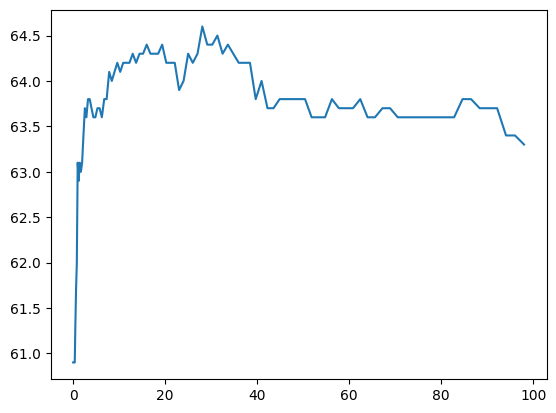

In [9]:
best_index = np.argmax(test_score_li)
best_c = expo_iter[best_index]
fig, ax = plt.subplots()
ax.plot(expo_iter, test_score_li)
plt.show()

In [10]:
best_index

np.int64(52)

In [11]:
best_c

np.float64(28.09)

In [12]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Tạo một dict param_grid với các giá trị kernel
param_grid = {'kernel': kernels}

# Tạo model SVM
svm_model = SVC(C=best_c)

# Áp dụng GridSearchCV với các kernel
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# In kernel tốt nhất và độ chính xác tương ứng
print("Kernel tốt nhất:", grid_search.best_params_['kernel'])
print("Độ chính xác tốt nhất:", grid_search.best_score_)

Kernel tốt nhất: rbf
Độ chính xác tốt nhất: 0.6277608915906788


In [15]:
svm = SVC(kernel='rbf', C=best_c)
svm.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
preds = svm.predict(X_test)

# Tính toán các chỉ số
conf_matrix = cm(y_test, preds)  
accuracy = acc(y_test, preds)   
precision = prec(y_test, preds)  
recall = rec(y_test, preds)      
f1 = f1(y_test, preds)          

# In kết quả
print("Best C:", best_c)
print("Confusion matrix:\n", conf_matrix)
print("Accuracy score:", accuracy)
print("Precision score:", precision)
print("Recall score:", recall)
print("F1 score:", f1)

Best C: 28.09
Confusion matrix:
 [[820  81]
 [443 135]]
Accuracy score: 0.6457065584854631
Precision score: 0.625
Recall score: 0.23356401384083045
F1 score: 0.34005037783375314


In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Perform cross-validation
cv_scores = cross_val_score(svm, X_train, y_train, cv=skf)
cv_accuracy = round(np.mean(cv_scores) * 100, 1)

print('Cross-Validation Accuracy Score: ', cv_accuracy, '%')


Cross-Validation Accuracy Score:  62.8 %


In [17]:
cv_scores

array([0.62962963, 0.61375661, 0.65608466, 0.63297872, 0.60638298])

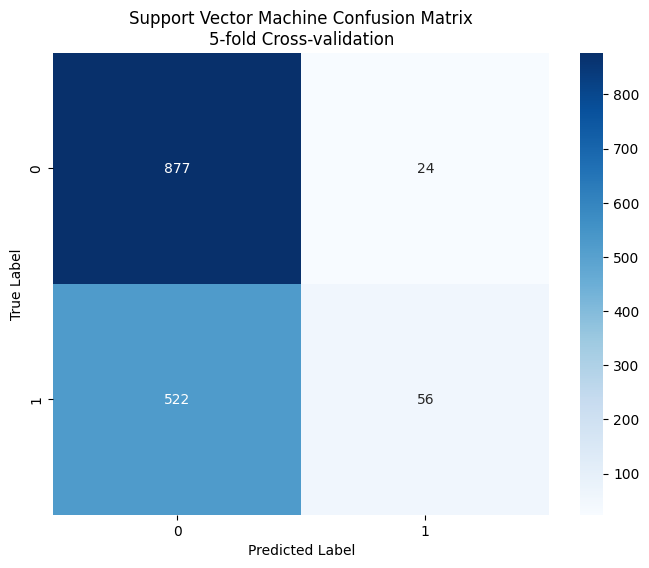

In [18]:
plot_cross_val_confusion_matrix(confusion_matrix, display_labels='', title='Support Vector Machine Confusion Matrix', cv=5)
plt.show()

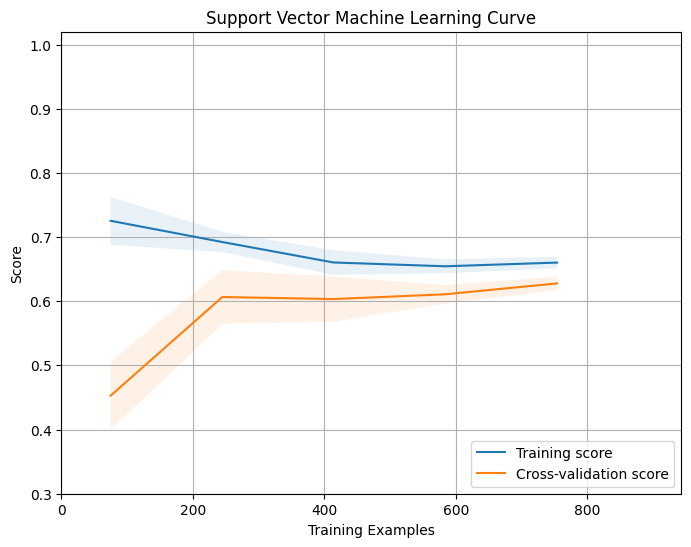

In [19]:
plot_learning_curve(svm, X_train, y_train, scoring='accuracy', training_set_size=5, cv=5, x_min=0, x_max=len(X_train), y_min=0.3, y_max=1.02, title='Support Vector Machine Learning Curve', leg_loc=4)
plt.show()